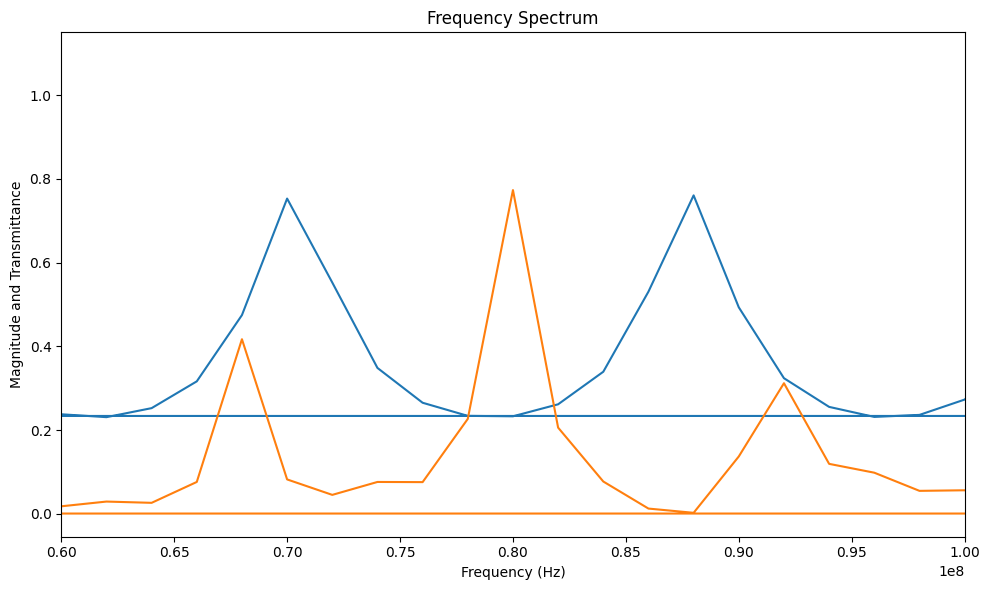

In [22]:
import math
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])

dt = spectr1[1] - spectr1[0]
fs = 1/dt
fft_signal = np.fft.fft(Spectr1)
freq = np.fft.fftfreq(len(Spectr1), d = dt)
#freq = freq[freq>0]
fft_signal_norm = fft_signal/max(fft_signal)

k1 = 0.38
k2 = 0.38
S1 = np.sqrt(k1)
S2 = np.sqrt(k2)
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
α = 0.1
L = 1.442
γ = np.exp(-α * L)

def t_filter_first(w):
    z = np.exp(1j*w)
    return  - (S1*S2*np.sqrt(γ/z)/(1-C1*C2*γ/z))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)

plt.figure(figsize = (10,6))
plt.plot(freq, np.abs(T_filter_first(freq)))
plt.plot(freq, np.abs(fft_signal_norm))
plt.xlim(60e6, 100e6)  # отображение только положительных частот
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude and Transmittance')
plt.title('Frequency Spectrum')

plt.tight_layout()
plt.show()

FWHM в МГЦ: 103.000102999073
FSR в МГЦ: 142.50014249871748


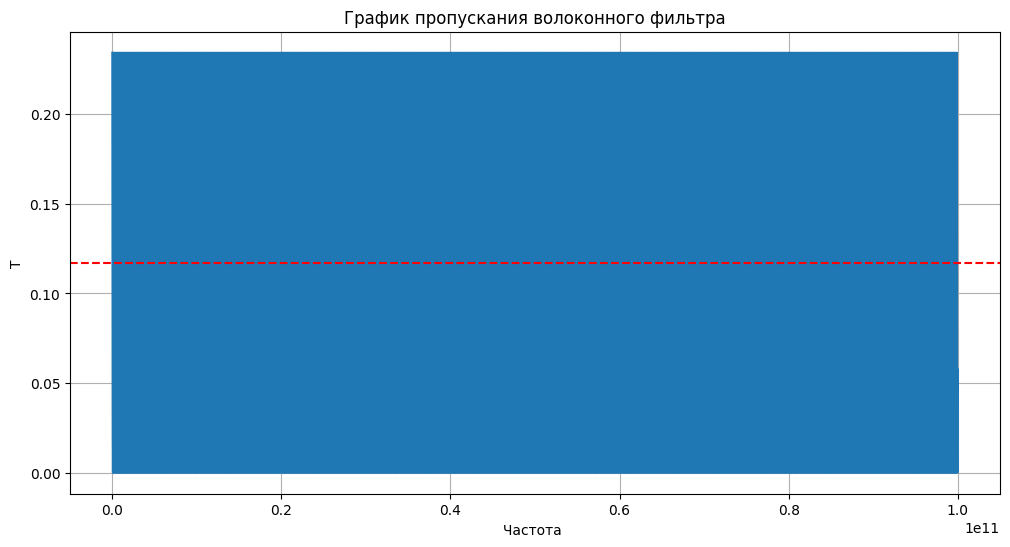

[1.000000e+00 1.000011e+05 2.000012e+05 ... 9.999980e+10 9.999990e+10
 1.000000e+11]


In [ ]:
import math
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
import pandas as pd
from scipy.signal import find_peaks
#%matplotlib qt 
df = pd.read_csv('praktik6.csv')
spectr1 = np.array(df.iloc[:,0])
Spectr1 = np.array(df.iloc[:,1])

dt = spectr1[1] - spectr1[0]
fs = 1/dt
fft_signal = np.fft.fft(Spectr1)
freq = np.fft.fftfreq(len(Spectr1), d = dt)
freq = freq[freq>0]
fft_signal_norm = fft_signal/max(fft_signal)
freq = np.linspace(1.0, 10e10, 1000000 )

k1 = 0.38
k2 = 0.38
n = 1.46
c = 3e8
S1 = np.sqrt(k1)
S2 = np.sqrt(k2)
C1 = np.sqrt(1-k1)
C2 = np.sqrt(1-k2)
α = 0.1
L = 1.442
γ = np.exp(-α * L)
T = n*L/c

def t_filter_first(w):
    z = np.exp(1j*w*2*np.pi*T)
    return  -(S1*S2*np.sqrt(γ*(z**(-1))/(1-C1*C2*γ*z**(-1))))
def T_filter_first(freq):
    result = []
    for w in freq:
        value = t_filter_first(w)
        result.append(value)
    return np.array(result)

T_values = np.abs(T_filter_first(freq))
#print(np.min(T_values))
T_values = T_values - 0.2852136704660684
max_amplitude = np.max(T_values)
half_max_amplitude = max_amplitude / 2
# Поиск точек пересечения с половиной максимума
crossings = []
for i in range(len(T_values)):
    if (T_values[i] - half_max_amplitude) * (T_values[i+1] - half_max_amplitude) <= 0:
        crossings.append((freq[i], T_values[i]))
    if len(crossings) == 2:
        fwhm = abs(crossings[1][0] - crossings[0][0])
        print(f"FWHM в МГЦ: {fwhm/1e6}")
        break
    #else:
        #print("Не найдено двух пересечений с половиной максимума.")
        
# Поиск пиков
peaks, _ = find_peaks(T_values)
# Определение максимального пика
print('FSR в МГЦ:', (freq[peaks[1]]-freq[peaks[0]])/1e6)
# Построим график зависимости модуля пропускания от частоты
plt.figure(figsize=(12, 6))
plt.plot(freq, T_values)
plt.axhline(half_max_amplitude, color='r', linestyle='--')  # линия половины максимума
#plt.xlim(60e6, 100e6)
plt.xlabel('Частота ')
plt.ylabel('T')
plt.title('График пропускания волоконного фильтра')
plt.grid(True)
plt.show()
#plt.plot(freq, np.abs(T_filter_first(freq)))